In [42]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.time import Time
from astropy import units as u

matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

# Define Functions

In [43]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c

async def retrieve_rotator_angle_and_torques_from_efd(client, start, end):
    """
    Retrieves the Rotator Angle and the Motors torques from the EFD.
    
    Parameters
    ----------
    client : EfdClient
        Interface that allows querying data from the EFD.
    start : datetime string
        ISOT Time in UTC associated to the start of the data.
    end : datetime string
        ISOT Time in UTC associated to the end of the data.
        
    Returns
    -------
    _df : DataFrame
        Table containing the queried data.
    """
    _df_rotator = await client.select_time_series(
        'lsst.sal.MTRotator.rotation', 
        fields='actualPosition', 
        start=start, 
        end=end)

    _df_motors = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields=['torque0', 'torque1', 'raw0', 'raw1', 'calibrated0', 'calibrated1'], 
        start=start, 
        end=end)

    _df = pd.merge(_df_rotator, _df_motors, left_index=True, right_index=True)
    _df = _df.dropna()
    
    return _df

# Get sal object Script messages from each test

In [44]:
#t_start = Time('2022-03-01T15:40:22.143140', scale='utc', format='isot') 
#t_end = Time('2022-03-01T18:52:17.886160', scale='utc', format='isot')
# Make a wide window covering all tests.

t_start = Time('2022-03-01T00:00', scale='utc', format='isot') 
t_end = Time('2022-04-30T00:00', scale='utc', format='isot')

In [98]:
summit = True
efd_client = retrieve_efd_client(summit)

# Specify here which ScriptID to use

#script_id = 42658886
script_id = 4368092

In [99]:
# Get all of the tests in the wide time period that used our ScriptID
# Also filter out the CSC start messages.

messages = await efd_client.select_time_series(
        "lsst.sal.Script.logevent_logMessage", 
        fields=['ScriptID','message'], 
        index = script_id,
        start=t_start, 
        end=t_end)

messages = messages.query('message != "Read historical data in 0.00 sec"')
messages.reset_index(inplace=True)

In [100]:
# Change display.max_rows to None to see all rows
# Change display.max_colwidth to 400 to see whole line

with pd.option_context('display.max_rows', 50, 'display.max_colwidth', 120):
    display(messages)

,index,ScriptID,message
0,2022-03-04 15:53:56.368000+00:00,4368092,START -- SUMMIT-6177 - Rotator movements in steps of 10 deg -- Starting Time: 2022-03-04 15:53:56.368308 UTC
1,2022-03-04 16:00:25.878000+00:00,4368092,END -- SUMMIT-6177 - Rotator movements in steps of 10 deg -- End Time: 2022-03-04 16:00:25.878484 UTC
2,2022-03-04 17:07:44.387000+00:00,4368092,START -- SUMMIT-6177 - Rotator movements in steps of 20 deg -- Starting Time: 2022-03-04 17:07:44.387246 UTC
3,2022-03-04 17:21:44.043000+00:00,4368092,FAIL -- SUMMIT-6177 - Rotator movements in steps of 20 deg -- End Time: 2022-03-04 17:21:44.043146 UTC
4,2022-03-04 17:22:14.088000+00:00,4368092,START -- SUMMIT-6177 - Rotator movements in steps of 10 deg -- Starting Time: 2022-03-04 17:22:14.087859 UTC
5,2022-03-04 17:28:21.967000+00:00,4368092,END -- SUMMIT-6177 - Rotator movements in steps of 10 deg -- End Time: 2022-03-04 17:28:21.967280 UTC
6,2022-03-04 17:29:07.323000+00:00,4368092,START -- SUMMIT-6177 - Rotator movements in steps of 20 deg -- Starting Time: 2022-03-04 17:29:07.323045 UTC
7,2022-03-04 17:39:46.277000+00:00,4368092,FAIL -- SUMMIT-6177 - Rotator movements in steps of 20 deg -- End Time: 2022-03-04 17:39:46.277441 UTC
8,2022-03-04 18:48:12.640000+00:00,4368092,START -- SUMMIT-6177 - Rotator movements in steps of 20 deg -- Starting Time: 2022-03-04 18:48:12.639902 UTC
9,2022-04-20 14:41:12.341000+00:00,4368092,START -- Rotator Torque Calibrations Test A -- Starting Time: 2022-04-20 14:41:12.341234 UTC


# Make a dataframe for the rotator data for each test.

In [101]:
# We don't know the conversion from torque to current.  USe this conversion factor.

CSC_factor = 1.0e6 # Mistaken factor in the CSC
torque_to_amps = CSC_factor * 4.6/1200 # current = torque * 4.6 Amp / 1200 N.m

In [102]:
# Examine the good tests by hand. Find the START/END pairs with no errors in between them.  
#
# Make a dataframe for each.

if script_id == 42658886:
    tests = [6, 10, 16, 18, 20, 24, 26, 33, 
            40, 42, 43, 44, 45, 46, 49, 52, 54, 65, 67, # Only 'START' no 'END' for test
            71, 73, 75, 77, 79, 81, 83, 
            86,                                         # Only 'START' no 'END' for test
            97, 99, 101, 103, 105, 107, 109, 111]
elif script_id == 4368092:
    tests = [17,    # A 
            25, 27, # B Together
            29, 31, # C Together
            33,     # D
            36,     # E
            38]     # F

In [103]:
# Build a data frame for each test. Start with an empty set of dataframes.


# Specify the maximum length a test can run in minutes.  
maximum_test_time = 22 # minutes

dfs = []

for i, test in enumerate(tests):
    
    print(f'{i} Test #{test} - {messages.message[test]:.130}')
    start_time = Time(messages['index'][test])
    stop_time = Time(messages['index'][test+1])
    
    if ((stop_time - start_time).to_value('min') > maximum_test_time):
        print(f'More than {maximum_test_time} minutes. Probably missing an END message. ' +
              f'Setting stop_time to start_time + {maximum_test_time} minutes')
        stop_time = start_time + maximum_test_time*u.minute
        
    df = await retrieve_rotator_angle_and_torques_from_efd(efd_client, start_time, stop_time)
    new = df.assign(test = test) \
            .assign(delta_time = (stop_time - start_time).to_value('min') ) \
            .assign(current0 = lambda x: torque_to_amps*x.torque0) \
            .assign(current1 = lambda x: torque_to_amps*x.torque1) \
            .assign(net_torque = lambda x: CSC_factor*(x.torque0 + x.torque1))
       
    #new = new.resample('100L').mean() # Resample in 1 second intervals
    dfs.append(new)

# Reset all the times to start at the first test
zero_time = dfs[0].index[0]
      
for i, test in enumerate(tests):
    dfs[i].index = (dfs[i].index - dfs[i].index[0]).total_seconds()/60.0 # to_offset(dfs[i].index[0] - zero_time)

0 Test #17 - START -- Rotator Torque Calibrations Test A -- Starting Time: 2022-04-20 16:27:23.172542 UTC
1 Test #25 - START -- Rotator Torque Calibrations Test B -- Starting Time: 2022-04-20 16:56:52.044069 UTC
2 Test #27 - START -- Rotator Torque Calibrations Test B -- Starting Time: 2022-04-20 17:32:32.913434 UTC
3 Test #29 - START -- Rotator Torque Calibrations Test C -- Starting Time: 2022-04-20 17:51:09.841784 UTC
4 Test #31 - START -- Rotator Torque Calibrations Test C -- Starting Time: 2022-04-20 17:57:49.550475 UTC
5 Test #33 - START -- Rotator Torque Calibrations Test D -- Starting Time: 2022-04-20 19:10:55.856749 UTC
6 Test #36 - START -- Rotator Torque Calibrations Test E -- Starting Time: 2022-04-20 19:30:56.385950 UTC
7 Test #38 - START -- Rotator Torque Calibrations Test F -- Starting Time: 2022-04-20 19:35:49.019538 UTC


In [104]:
%%script echo Skipping Cell

# Use this to look at a dataframe

index = 0

print(f'Test #{tests[index]} - {messages.message[tests[index]]}')
display(dfs[index])

Skipping Cell


In [106]:
%%script echo Skipping Cell

# Use this to print the tests and how many entries there are in each test

for i, test in enumerate(tests):
    print(f'{i:3d} {test:3d} {dfs[i].delta_time[0]:10.2f} {len(dfs[i]):8d}')

Skipping Cell


# Make Plots

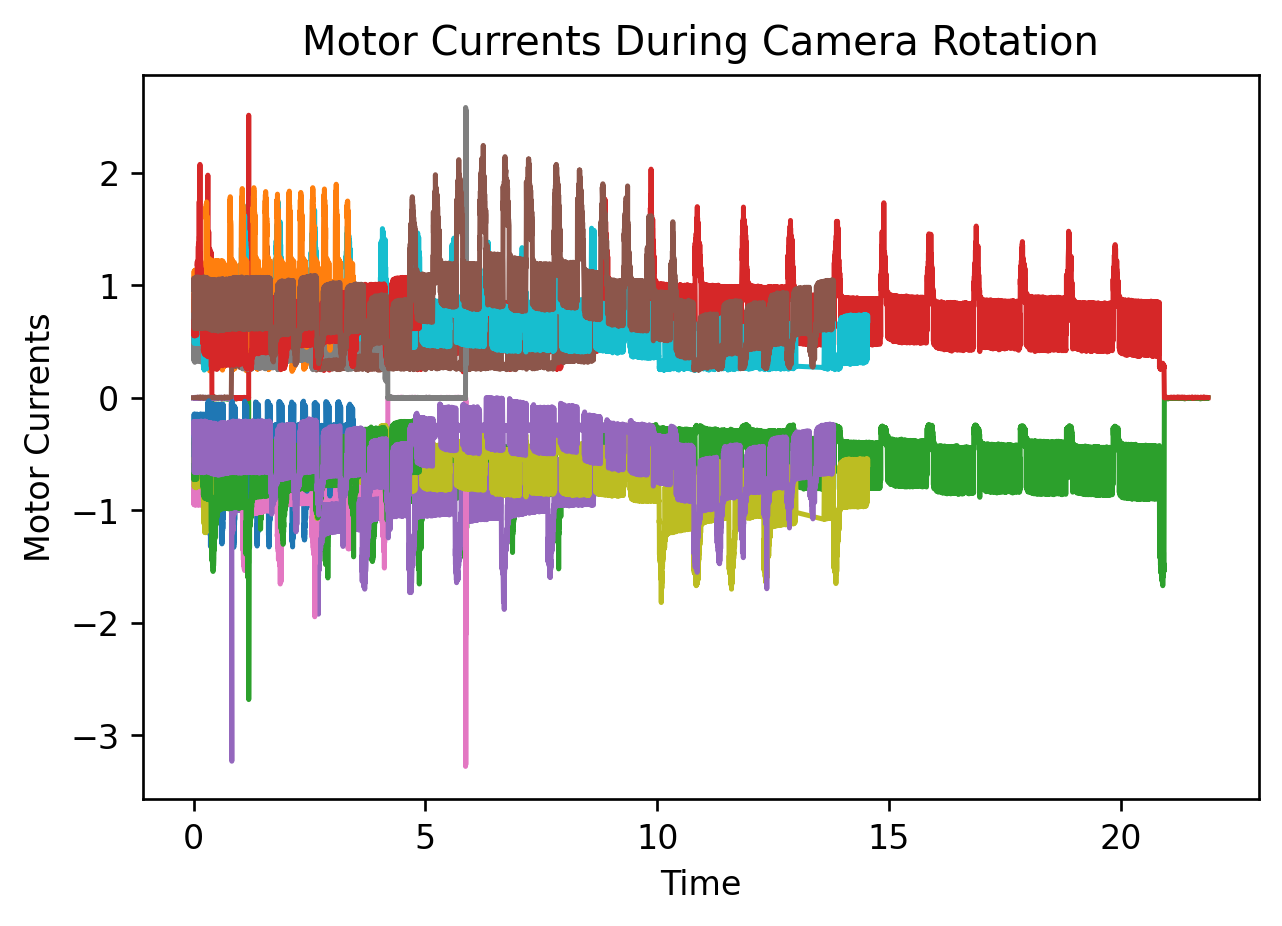

In [107]:
for i, test in enumerate(tests):
    #dfs[i].actualPosition.plot(label=f'{tests[i]}')
    dfs[i].current0.plot(label=f'{tests[i]}')
    dfs[i].current1.plot(label=f'{tests[i]}')
    
plt.title(r'Motor Currents During Camera Rotation')
plt.xlabel(r'Time')
plt.ylabel(r'Motor Currents');
#plt.legend(ncol=2, loc='lower left', fontsize=8)


In [108]:
if script_id == 42658886:
    ax1 = dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", color='b', s=20.0, label=f'{tests[0]}')
    ax2 = dfs[1].plot.scatter('actualPosition', 'net_torque', marker=".", color='g', s=20.0, ax=ax1, label=f'{tests[1]}')
    ax3 = dfs[2].plot.scatter('actualPosition', 'net_torque', marker=".", color='r', s=20.0, ax=ax1, label=f'{tests[2]}')
    ax4 = dfs[3].plot.scatter('actualPosition', 'net_torque', marker=".", color='c', s=20.0, ax=ax1, label=f'{tests[3]}')
    ax5 = dfs[4].plot.scatter('actualPosition', 'net_torque', marker=".", color='m', s=20.0, ax=ax1, label=f'{tests[4]}')
    ax6 = dfs[5].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{tests[5]}')
    ax7 = dfs[6].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{tests[5]}')
    ax8 = dfs[7].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{tests[5]}')


    plt.title(r'Net Torque During Camera Rotation on 03/01/22')
    #plt.ylim(-.001, .001)
    #plt.ylim(-1000, 1000)

    plt.xticks(rotation=45)
    plt.xlabel(r'Rotator Angle')
    plt.ylabel(r'Total Torque (N*m)');

    plt.legend(ncol=2, loc='lower left', fontsize=8)

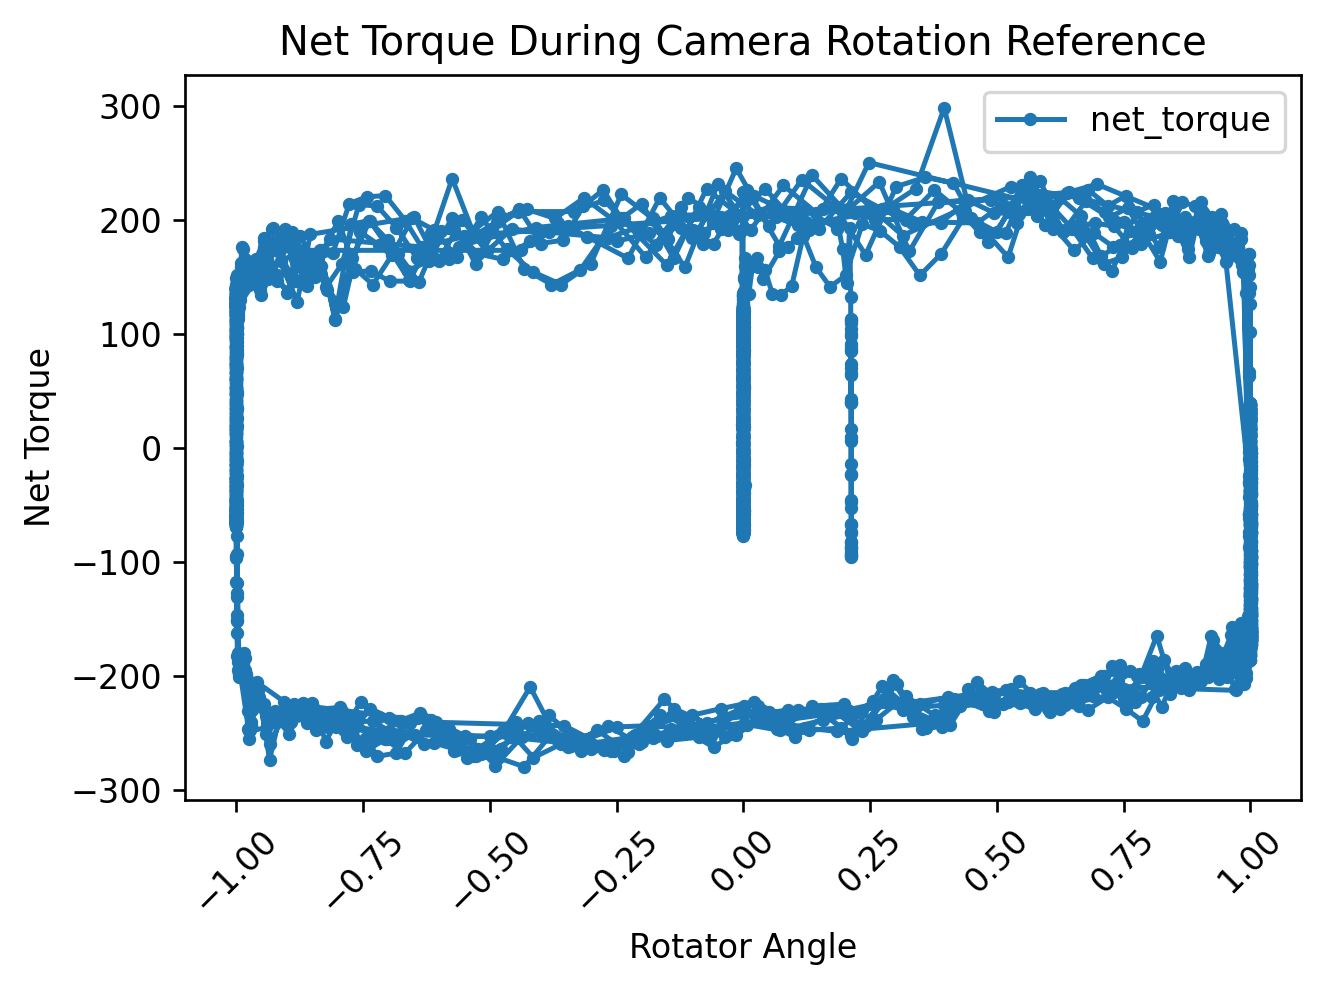

In [109]:
dfs[0].plot('actualPosition', 'net_torque', marker='.')

plt.title(r'Net Torque During Camera Rotation Reference')
#plt.xlim(-90, 0)
#plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Net Torque');

In [110]:
def draw_rotator_tests(title, layout, test_start, test_stop, max_minutes=None):
    '''
    Draw a set of rotator tests on a given day. Show the motor currents vs time. 
    '''
    
    fig, axes = plt.subplot_mosaic(layout, sharex=True, sharey=True, constrained_layout=True, figsize=(11, 8))

    for i, test in enumerate(range(test_start, test_stop+1)):
        #print(i, test, tests[test], layout.replace('\n','')[i])
        
        # Draw the current for the two motors
        cell = layout.replace('\n','')[i]
        dfs[test].current0.plot(ax=axes[cell], linewidth=0.50)
        dfs[test].current1.plot(ax=axes[cell], linewidth=0.50)
        
        if max_minutes != None:
            axes[cell].set_xlim(0, max_minutes)
        
        # Draw current limits 
        axes[cell].set_ylim(-5,5)
        axes[cell].axhline(4.6, linestyle='--', color='magenta')
        axes[cell].axhline(-4.6, linestyle='--', color='magenta')
        
        # Make 2nd y-axis on right for rotator position
        axes2 = axes[cell].twinx()
        axes2.set_yticks([])
        dfs[test].actualPosition.plot(ax=axes2, color='green', linewidth=0.50)
        axes2.set_ylim(-90,90)
    
    fig.suptitle(title)
    fig.supxlabel("Time (minutes)")
    fig.supylabel("Motor Current (Amps)")

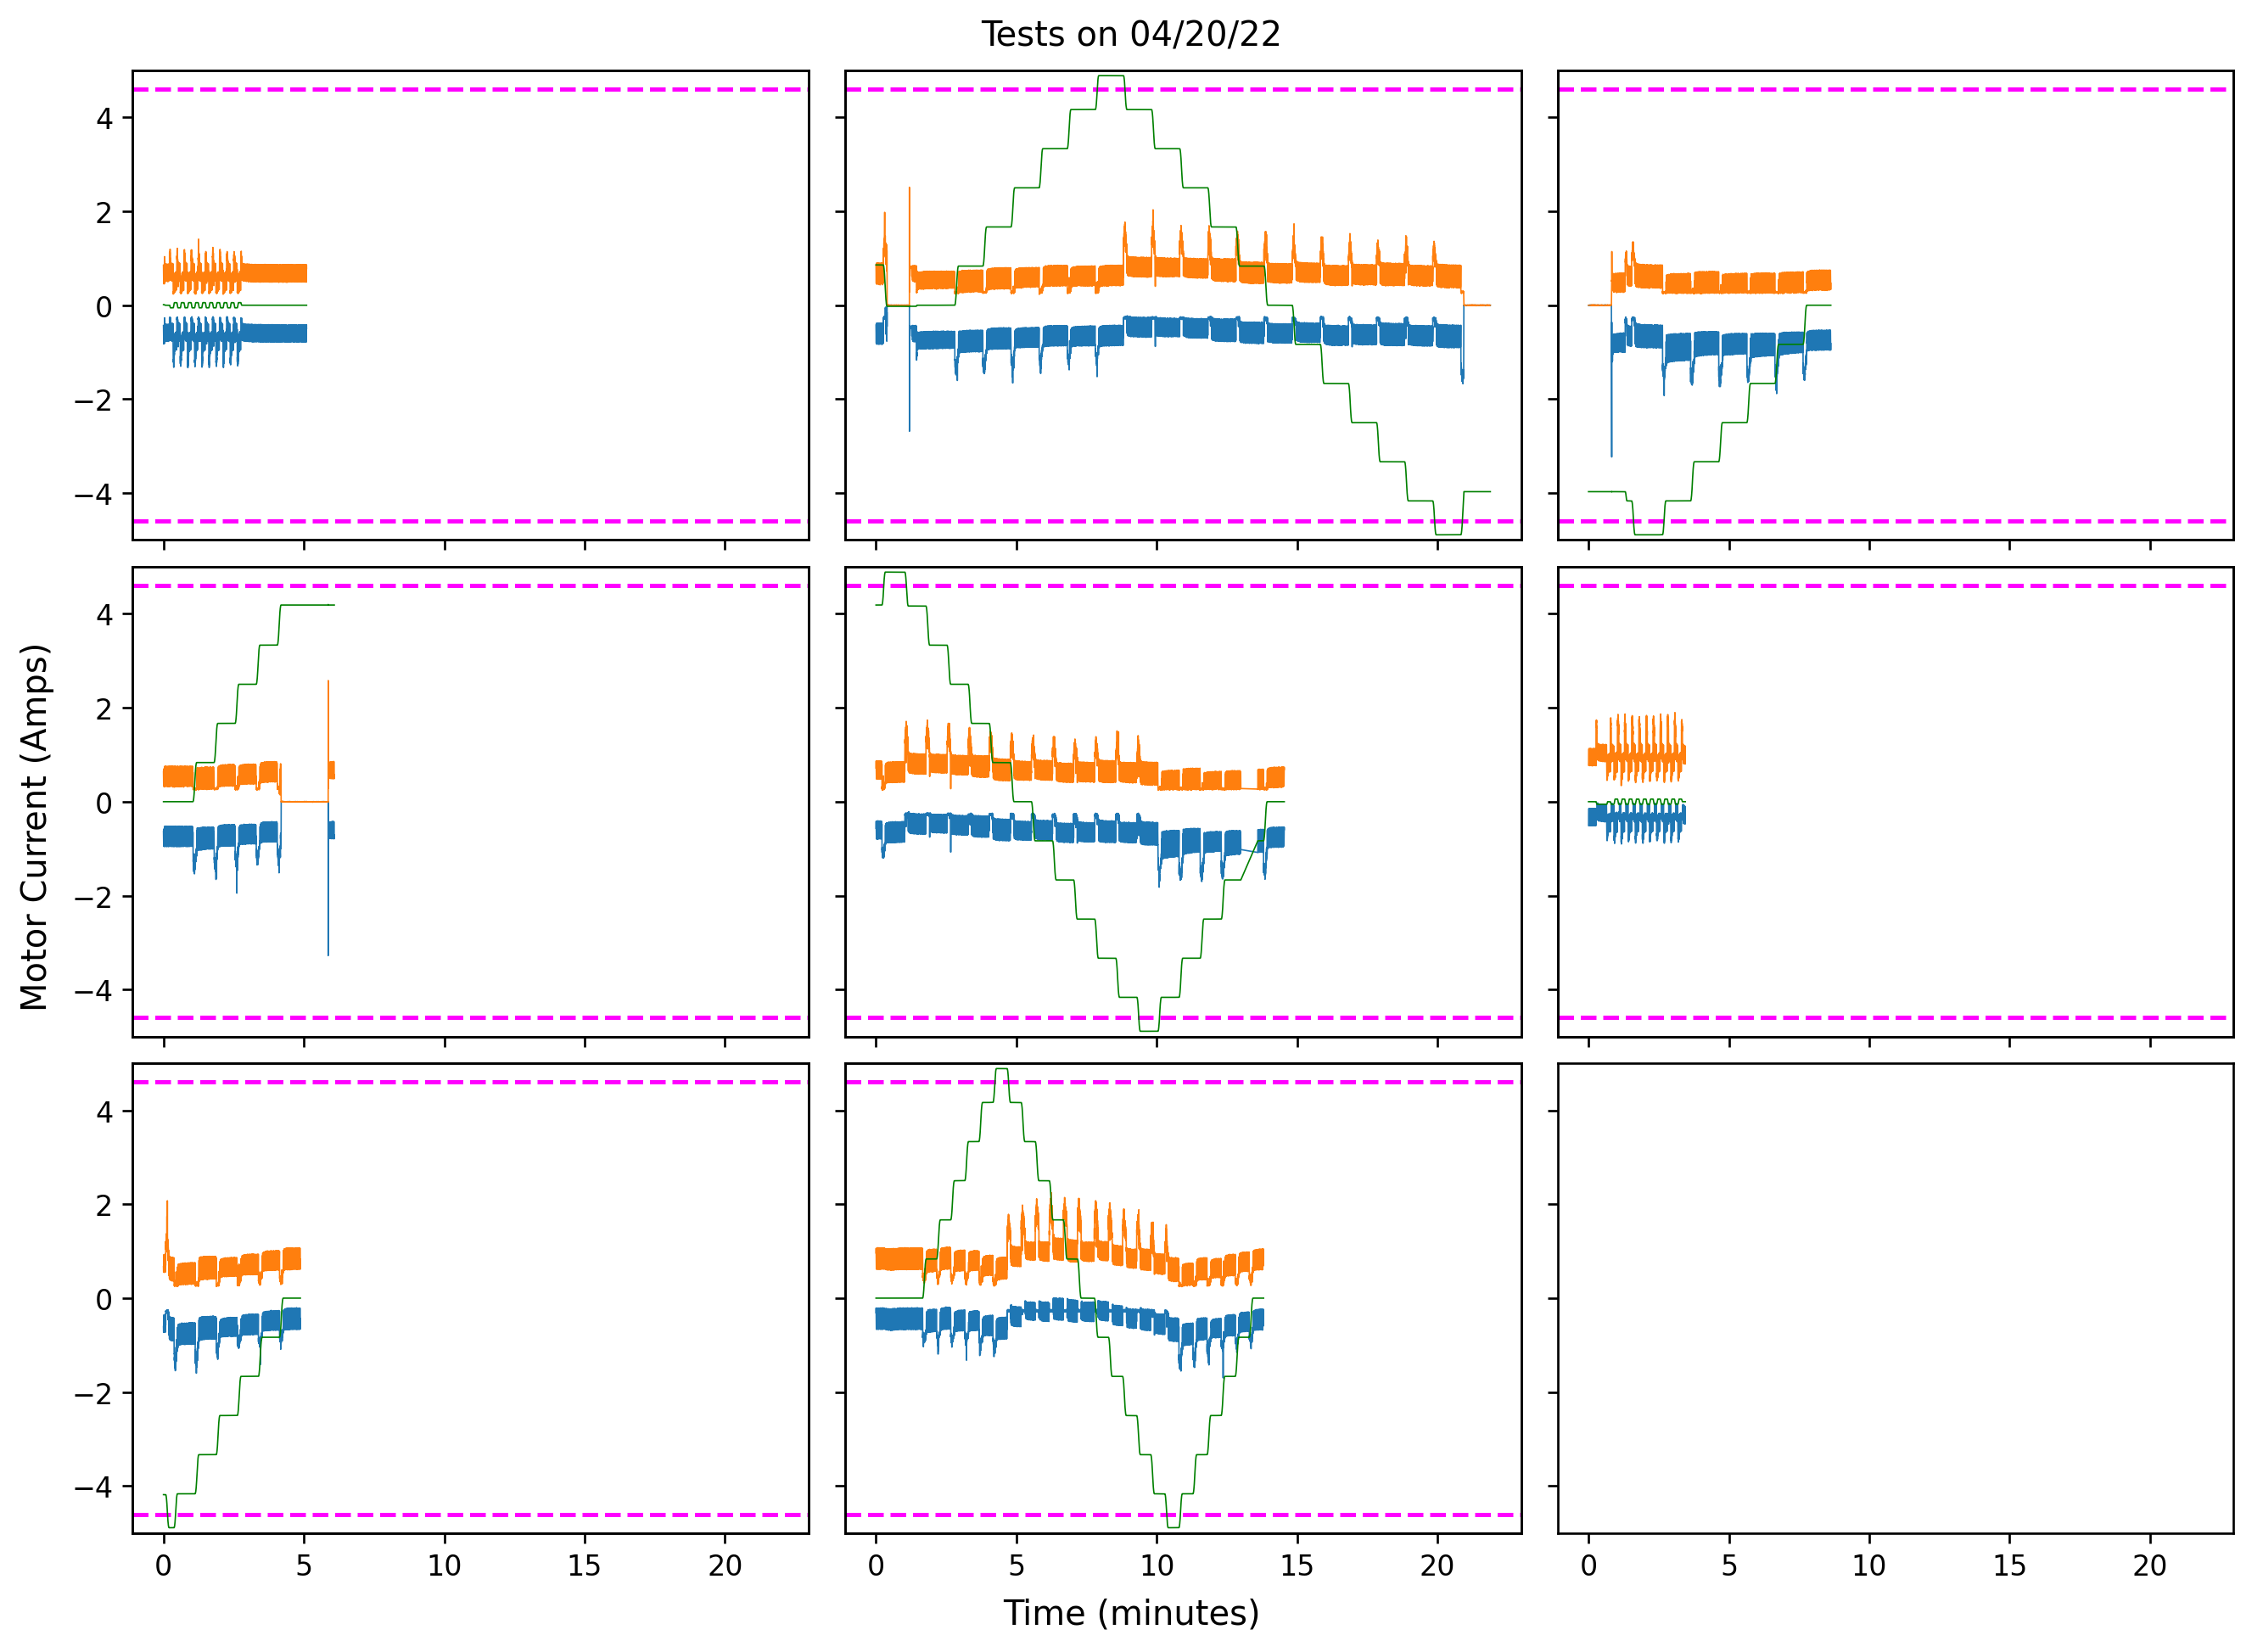

In [111]:
layout_3x1 = '''
ABC
'''

layout_3x3 = '''
ABC
DEF
GHI
'''

layout_3x4 = '''
ABC
DEF
GHI
JKL
'''

if script_id == 42658886:
    draw_rotator_tests('Tests on 03/01/22',layout_3x3, 0, 7)
    draw_rotator_tests('Tests on 03/10/22',layout_3x4, 8, 18, max_minutes=15)
    draw_rotator_tests('Tests on 04/06/22',layout_3x3, 19, 26, max_minutes=15)
    draw_rotator_tests('Tests on 04/12/22',layout_3x3, 27, 34, max_minutes=10)
if script_id == 4368092:
    draw_rotator_tests('Tests on 04/20/22',layout_3x3, 0, 7)